<a href="https://colab.research.google.com/github/Blockchain-Framework/bitcoin-anomaly-analysis/blob/develop/Notebooks/Bitcoin_AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [68]:
train = pd.read_csv('/content/drive/MyDrive/bitcoin_imbalance_train_set.csv')
test = pd.read_csv("/content/drive/MyDrive/bitcoin_imbalance_test.csv")

In [69]:
original_feature_names = ['input_transaction_count', 'output_transaction_count',
       'input_value_mean', 'input_value_median', 'input_value_maximum',
       'input_value_minimum', 'input_value_25th_percentile',
       'input_value_75th_percentile', 'input_value_range',
       'input_spending_value_usd_mean', 'input_spending_value_usd_median',
       'input_spending_value_usd_maximum', 'input_spending_value_usd_minimum',
       'input_spending_value_usd_25th_percentile',
       'input_spending_value_usd_75th_percentile',
       'input_spending_value_usd_range', 'input_time_diff_mean',
       'input_time_diff_median', 'input_time_diff_maximum',
       'input_time_diff_minimum', 'input_time_diff_25th_percentile',
       'input_time_diff_75th_percentile', 'input_time_diff_range',
       'output_value_usd_mean', 'output_value_usd_median',
       'output_value_usd_maximum', 'output_value_usd_minimum',
       'output_value_usd_25th_percentile', 'output_value_usd_75th_percentile',
       'output_value_usd_range', 'output_time_diff_mean',
       'output_time_diff_median', 'output_time_diff_maximum',
       'output_time_diff_minimum', 'output_time_diff_25th_percentile',
       'output_time_diff_75th_percentile', 'output_time_diff_range',
       'output_value_mean', 'output_value_median', 'output_value_maximum',
       'output_value_minimum', 'output_value_25th_percentile',
       'output_value_75th_percentile', 'output_value_range',
       'input_output_mean_ratio', 'input_output_max_ratio',
       'input_output_min_ratio', 'input_output_percentile_25_diff',
       'input_output_percentile_75_diff', 'range_mean_ratio_input',
       'range_mean_ratio_output', 'input_output_usd_mean_ratio',
       'input_output_usd_max_ratio', 'input_output_usd_min_ratio',
       'input_output_usd_percentile_25_diff',
       'input_output_usd_percentile_75_diff', 'input_range_mean_ratio',
       'output_range_mean_ratio', 'input_output_transaction_count_ratio',
       'input_output_maximum_transaction_value_diff',
       'input_output_minimum_transaction_value_diff',
       'input_output_time_diff_max_min_diff']

In [70]:
X_train = train[original_feature_names]
y_train = train['label']

In [71]:
y_train = y_train.apply(lambda x: 1 if x in [1, 2, 3] else 0)

In [72]:
X_test = test[original_feature_names]
y_test = test['label']

In [73]:
y_test = y_test.apply(lambda x: 1 if x in [1, 2, 3] else 0)

In [9]:
X = X_train.copy()

selector = VarianceThreshold()
X_var = selector.fit_transform(X)

# Calculate correlation matrix
corr_matrix = pd.DataFrame(X_var, columns=X.columns[selector.get_support()]).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop highly correlated features
X_uncorr = pd.DataFrame(X_var, columns=X.columns[selector.get_support()]).drop(to_drop, axis=1)

<ipython-input-9-fe668c7d19a9>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [10]:
X_train = X_train[X_uncorr.columns]
X_test = X_test[X_uncorr.columns]

In [11]:
!pip install tensorflow

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

class Autoencoder():
    def __init__(self, input_dim, intermediate_dim=64, latent_dim=32, dropout_rate=0.2):
        self.input_dim = input_dim
        self.intermediate_dim = intermediate_dim
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        self.input = Input(shape=(self.input_dim,))

    def build_encoder(self):
        x = self.input
        x = Dense(self.intermediate_dim, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(self.dropout_rate)(x)
        encoded_output = Dense(self.latent_dim, activation='relu')(x)
        return Model(self.input, encoded_output)

    def build_decoder(self):
        encoded_input = Input(shape=(self.latent_dim,))
        x = Dense(self.intermediate_dim, activation='relu')(encoded_input)
        x = BatchNormalization()(x)
        x = Dropout(self.dropout_rate)(x)
        decoder_output = Dense(self.input_dim, activation='sigmoid')(x)
        return Model(encoded_input, decoder_output)

    def build_model(self):
        encoder = self.build_encoder()
        decoder = self.build_decoder()
        autoencoder_output = decoder(encoder(self.input))
        return Model(self.input, autoencoder_output)

class ADAE(object):
    def __init__(self, input_dim, latent_dim=32, learning_rate=0.001):
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.input = Input(shape=(input_dim,))
        self.generator = Autoencoder(input_dim=input_dim, latent_dim=latent_dim).build_model()
        self.discriminator = Autoencoder(input_dim=input_dim, latent_dim=latent_dim).build_model()

        self.gx = self.generator(self.input)
        self.dx = self.discriminator(self.input)
        self.dgx = self.discriminator(self.gx)

        self.d_loss = Lambda(lambda x: tf.reduce_mean(tf.abs(x[0] - x[1])) - tf.reduce_mean(tf.abs(x[2] - x[3])), name='d_loss')([self.input, self.dx, self.gx, self.dgx])
        self.g_loss = Lambda(lambda x: tf.reduce_mean(tf.abs(x[0] - x[1])) + tf.reduce_mean(tf.abs(x[1] - x[2])), name='g_loss')([self.input, self.gx, self.dgx])

        self.model = Model(inputs=[self.input], outputs=[self.g_loss, self.d_loss])
        self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss={'g_loss': 'mean_absolute_error', 'd_loss': 'mean_absolute_error'})

    def train(self, x_train, epochs=50, batch_size=32, validation_data=None):
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint('adae_best_model.h5', monitor='val_loss', save_best_only=True)
        tensorboard_callback = TensorBoard(log_dir='./logs')

        for epoch in range(epochs):
            print(f'Epoch {epoch+1}/{epochs}')
            # Train generator
            self.generator.trainable = True
            self.discriminator.trainable = False
            self.model.fit(x_train, batch_size=batch_size, epochs=1, validation_data=validation_data, callbacks=[early_stopping, model_checkpoint, tensorboard_callback])

            # Train discriminator
            self.generator.trainable = False
            self.discriminator.trainable = True
            self.model.fit(x_train, batch_size=batch_size, epochs=1, validation_data=validation_data, callbacks=[early_stopping, model_checkpoint, tensorboard_callback])

# Example usage
# adae = ADAE(input_dim=23)
# adae.train(x_train, epochs=200, batch_size=64, validation_data=(x_val, y_val))


In [74]:
X_train.shape

(72809, 62)

In [16]:
input_dim = 23  # As per your dataset
class_weight = {0: 1, 1: 40001/32808}  # Adjust class weights for the slight imbalance

adae = ADAE(input_dim=input_dim)
adae.train(X_train, y_train, epochs=200, batch_size=64, class_weight=class_weight)

Epoch 1/200
1138/1138 [==============================] - 5s 4ms/step - loss: 30924952.0000 - g_loss_loss: 15462476.0000 - d_loss_loss: 15462476.0000
Epoch 2/200
1138/1138 [==============================] - 5s 4ms/step - loss: 30924210.0000 - g_loss_loss: 15462105.0000 - d_loss_loss: 15462105.0000
Epoch 3/200
1138/1138 [==============================] - 5s 4ms/step - loss: 31043612.0000 - g_loss_loss: 15521806.0000 - d_loss_loss: 15521806.0000
Epoch 4/200
1138/1138 [==============================] - 5s 4ms/step - loss: 30890072.0000 - g_loss_loss: 15445036.0000 - d_loss_loss: 15445036.0000
Epoch 5/200
1138/1138 [==============================] - 6s 5ms/step - loss: 31135120.0000 - g_loss_loss: 15567560.0000 - d_loss_loss: 15567560.0000
Epoch 6/200
1138/1138 [==============================] - 7s 6ms/step - loss: 31068476.0000 - g_loss_loss: 15534238.0000 - d_loss_loss: 15534238.0000
Epoch 7/200
1138/1138 [==============================] - 7s 6ms/step - loss: 31059220.0000 - g_loss_loss: 

## Auto Encoder

In [81]:
X_train.head()

,input_transaction_count,output_transaction_count,input_value_mean,input_value_median,input_value_maximum,input_value_minimum,input_value_25th_percentile,input_value_75th_percentile,input_value_range,input_spending_value_usd_mean,...,input_output_usd_max_ratio,input_output_usd_min_ratio,input_output_usd_percentile_25_diff,input_output_usd_percentile_75_diff,input_range_mean_ratio,output_range_mean_ratio,input_output_transaction_count_ratio,input_output_maximum_transaction_value_diff,input_output_minimum_transaction_value_diff,input_output_time_diff_max_min_diff
0,5.0,5.0,4126654.4,3775772.0,10000000.0,100000.0,1757500.0,5000000.0,9900000.0,876.2368,...,0.915961,0.970265,165.8845,664.1546,1.932576,2.705312,1.0,0.0,0.0,-15775957.0
1,1.0,1.0,139863.0,139863.0,139863.0,139863.0,139863.0,139863.0,0.0,14.7539,...,0.987312,0.987312,-0.1896,-0.1896,0.000000,0.000000,1.0,0.0,0.0,0.0
2,1.0,1.0,4600000.0,4600000.0,4600000.0,4600000.0,4600000.0,4600000.0,0.0,441.1833,...,0.911570,0.911570,-42.7983,-42.7983,0.000000,0.000000,1.0,0.0,0.0,0.0
3,1.0,1.0,2538940.0,2538940.0,2538940.0,2538940.0,2538940.0,2538940.0,0.0,244.3648,...,1.395747,1.395747,69.2866,69.2866,0.000000,0.000000,1.0,0.0,0.0,0.0
4,1.0,1.0,739047.0,739047.0,739047.0,739047.0,739047.0,739047.0,0.0,78.9625,...,1.044800,1.044800,3.3858,3.3858,0.000000,0.000000,1.0,0.0,0.0,0.0


In [13]:
X_train.describe()

,input_transaction_count,input_value_mean,input_value_median,input_value_maximum,input_value_range,input_time_diff_mean,input_time_diff_median,input_time_diff_maximum,output_time_diff_mean,output_time_diff_median,...,input_output_min_ratio,input_output_percentile_25_diff,input_output_percentile_75_diff,range_mean_ratio_input,input_output_usd_min_ratio,input_output_usd_percentile_25_diff,input_output_transaction_count_ratio,input_output_maximum_transaction_value_diff,input_output_minimum_transaction_value_diff,input_output_time_diff_max_min_diff
count,72809.000000,7.280900e+04,7.280900e+04,7.280900e+04,7.280900e+04,7.280900e+04,7.280900e+04,7.280900e+04,7.280900e+04,7.280900e+04,...,7.280900e+04,7.280900e+04,7.280900e+04,72809.000000,7.280900e+04,7.280900e+04,72809.000000,7.280900e+04,7.280900e+04,7.280900e+04
mean,26.879067,5.650357e+07,4.252036e+07,1.175935e+08,8.674475e+07,9.898908e+05,6.454594e+05,3.246408e+06,8.607707e+05,5.327643e+05,...,2.307282e+02,2.133891e+05,9.410914e+06,1.086191,3.658884e+02,1.495875e+02,0.944744,1.073170e+05,1.389575e+05,3.623017e+05
std,1493.824322,5.278444e+09,4.817996e+09,8.489542e+09,7.130977e+09,2.797530e+06,2.373526e+06,8.195608e+06,2.595094e+06,2.140244e+06,...,2.532811e+04,1.533787e+07,2.422476e+09,6.845113,4.615341e+04,1.278280e+04,0.224074,1.398224e+07,1.511482e+07,4.121675e+06
min,1.000000,5.460000e+02,5.460000e+02,5.460000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.884838e-06,-1.125000e+09,-7.500000e+09,0.000000,2.376534e-06,-3.353101e+05,0.018182,-2.000000e+08,-1.500000e+09,-7.695281e+07
25%,1.000000,3.317813e+05,2.817175e+05,3.947460e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000e+00,-3.122500e-02,1.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000,1.436571e+06,1.235596e+06,1.836390e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.000000,6.708028e+06,5.582050e+06,1.006000e+07,1.309200e+06,4.961290e+05,9.073500e+04,2.061597e+06,3.848993e+05,8.408600e+04,...,1.000000e+00,0.000000e+00,0.000000e+00,1.169302,1.018149e+00,6.246000e-01,1.000000,0.000000e+00,0.000000e+00,0.000000e+00
max,261326.000000,1.197964e+12,1.197964e+12,1.307060e+12,1.307060e+12,4.377716e+07,4.377716e+07,9.039358e+07,3.609437e+07,3.609437e+07,...,4.178587e+06,2.285687e+09,6.535291e+11,1196.172753,8.782255e+06,3.168024e+06,22.750000,2.285687e+09,2.285687e+09,7.906209e+07


In [12]:
X_train = X_train.abs()
X_test = X_test.abs()

In [16]:
!pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=39cd9be3b7bc8149c187db9d4a03e28ed341f5abe42eee73e1b4a36686aeb863
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [15]:
!pip install umap-learn[plot]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 39.7 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=2f17f9212458e4de5c330d83bfbb262bd4375fe301d8db2e131fc239d6e59d43
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import umap
import umap.plot

from plotly.subplots import make_subplots
import plotly.graph_objects as go

ModuleNotFoundError: No module named 'umap'

In [17]:
colors = ['gold', 'mediumturquoise']
labels = ['Normal','Abnormal']
values = y_train.value_counts()/y_train.shape[0]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='white', width=0.1)))
fig.update_layout(
    title_text="Bitcoin dataset",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
)
fig.show()

In [13]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)

    roc_auc = roc_auc_score(y_test, pred_proba)
    print('confusion matrix')
    print(confusion)

    # ROC-AUC print
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

In [75]:
train_data, val_data, train_labels, val_labels = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [76]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the training data and transform the training data
X_train_normalized = scaler.fit_transform(train_data)

X_val_normalized = scaler.transform(val_data)
X_test_normalized = scaler.transform(X_test)


In [21]:
train_labels = train_labels.astype(bool)
val_labels = val_labels.astype(bool)
y_test = y_test.astype(bool)

In [37]:

normal_class_indices = y_train == 0
X_train_nromal = X_train[normal_class_indices]


In [38]:
abnormal_class_indices = y_train == 1

# Select only the rows from X_train corresponding to the positive class
X_train_abnromal = X_train[abnormal_class_indices]

In [33]:
X_train.columns

Index(['input_transaction_count', 'input_value_mean', 'input_value_median',
       'input_value_maximum', 'input_value_range', 'input_time_diff_mean',
       'input_time_diff_median', 'input_time_diff_maximum',
       'output_time_diff_mean', 'output_time_diff_median',
       'output_time_diff_maximum', 'input_output_mean_ratio',
       'input_output_max_ratio', 'input_output_min_ratio',
       'input_output_percentile_25_diff', 'input_output_percentile_75_diff',
       'range_mean_ratio_input', 'input_output_usd_min_ratio',
       'input_output_usd_percentile_25_diff',
       'input_output_transaction_count_ratio',
       'input_output_maximum_transaction_value_diff',
       'input_output_minimum_transaction_value_diff',
       'input_output_time_diff_max_min_diff'],
      dtype='object')

Text(0.5, 1.0, 'A Normal Address')

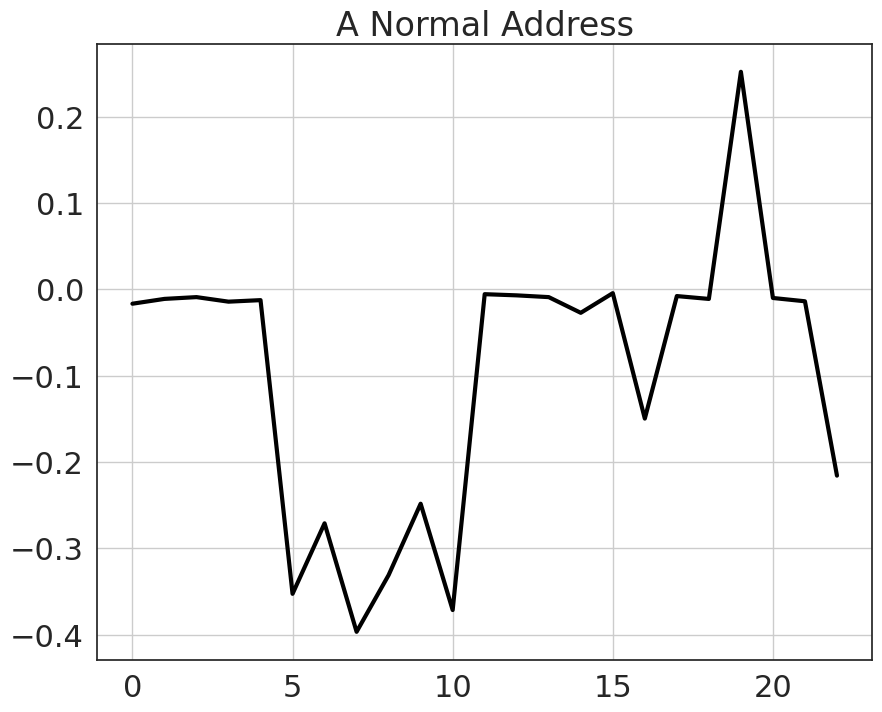

In [29]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.grid()
plt.plot(np.arange(23), X_train_nromal[0],color='black',linewidth=3.0)
plt.title("A Normal Address")

Text(0.5, 1.0, 'A Normal Address')

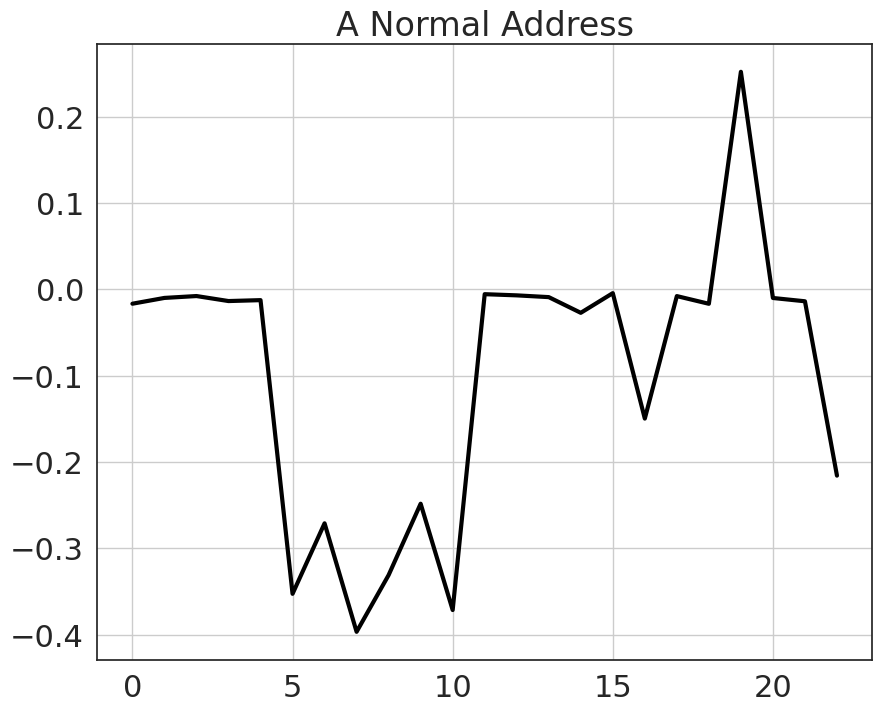

In [34]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.grid()
plt.plot(np.arange(23), X_train_nromal[1],color='black',linewidth=3.0)
plt.title("A Normal Address")

In [42]:
X_train_nromal['input_value_mean'].describe()

count    4.000100e+04
mean     1.714920e+07
std      1.375254e+08
min      5.460000e+02
25%      1.000000e+05
50%      9.078462e+05
75%      4.726379e+06
max      1.009997e+10
Name: input_value_mean, dtype: float64

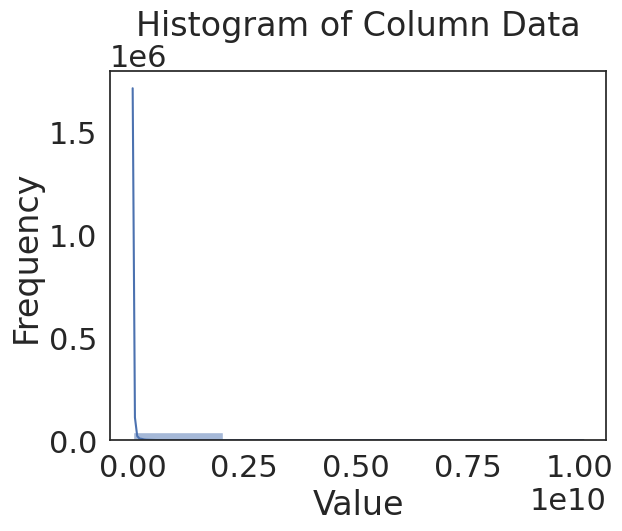

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'column_data' is your numeric column
sns.histplot(X_train_nromal['input_value_mean'], bins=5, kde=True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Column Data')
plt.show()

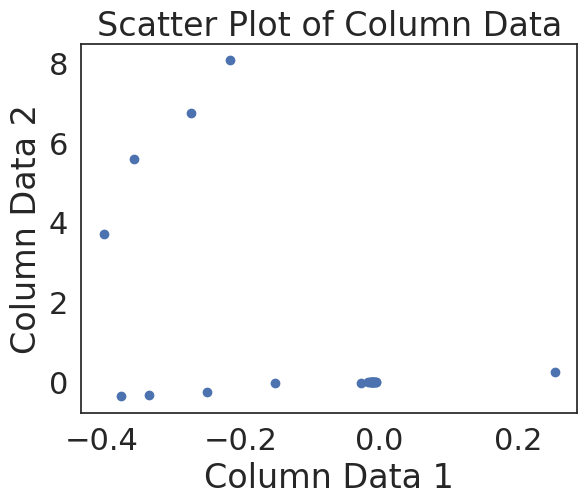

In [36]:
# Assuming 'column_data1' and 'column_data2' are your numeric columns
plt.scatter(X_train_nromal[0], X_train_abnromal[0])
plt.xlabel('Column Data 1')
plt.ylabel('Column Data 2')
plt.title('Scatter Plot of Column Data')
plt.show()


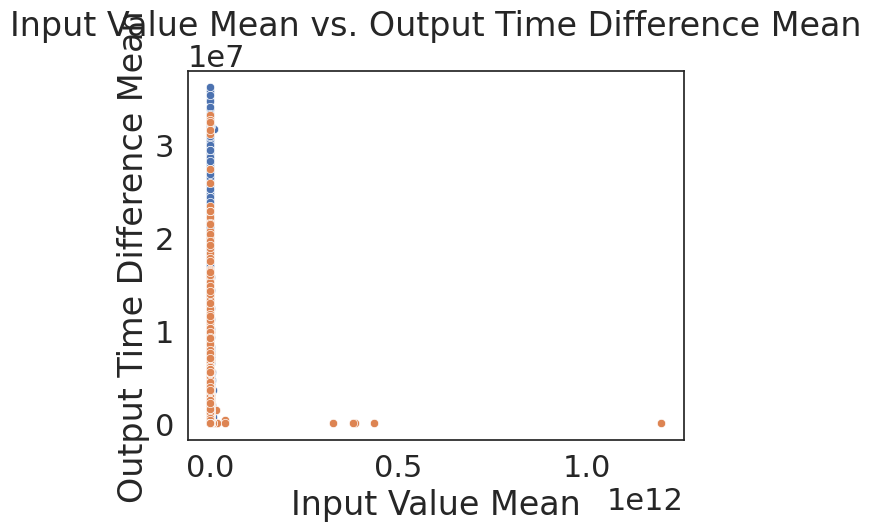

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your DataFrame
sns.scatterplot(x='input_value_mean', y='output_time_diff_mean', data=X_train_nromal)
sns.scatterplot(x='input_value_mean', y='output_time_diff_mean', data=X_train_abnromal)

plt.xlabel('Input Value Mean')
plt.ylabel('Output Time Difference Mean')
plt.title('Input Value Mean vs. Output Time Difference Mean')
plt.show()


In [ ]:
X_train_normal = X_train_nromal
X_train_abnormal = X_train_abnormal

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Apply a log transformation to the data if it spans several orders of magnitude
# Use np.log1p for log(1+x) to avoid issues with log(0)
X_train_normal['input_value_mean_log'] = np.log1p(X_train_normal['input_value_mean'])
X_train_abnormal['input_value_mean_log'] = np.log1p(X_train_abnormal['input_value_mean'])
X_train_normal['output_time_diff_mean_log'] = np.log1p(X_train_normal['output_time_diff_mean'])
X_train_abnormal['output_time_diff_mean_log'] = np.log1p(X_train_abnormal['output_time_diff_mean'])

# Plotting with log-transformed data and alpha blending for overlap
sns.scatterplot(x='input_value_mean_log', y='output_time_diff_mean_log', data=X_train_normal, alpha=0.5, label='Normal')
sns.scatterplot(x='input_value_mean_log', y='output_time_diff_mean_log', data=X_train_abnormal, alpha=0.5, label='Abnormal')

plt.xlabel('Log of Input Value Mean')
plt.ylabel('Log of Output Time Difference Mean')
plt.title('Log of Input Value Mean vs. Log of Output Time Difference Mean')
plt.legend()
plt.show()


NameError: name 'X_train_normal' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming normal_data and abnormal_data are your datasets with two columns each
# Replace 'feature1' and 'feature2' with your actual feature/column names
sns.scatterplot(x='feature1', y='feature2', data=normal_data, label='Normal', color='blue')
sns.scatterplot(x='feature1', y='feature2', data=abnormal_data, label='Abnormal', color='red')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Comparison of Normal and Abnormal Classes')
plt.legend()
plt.show()


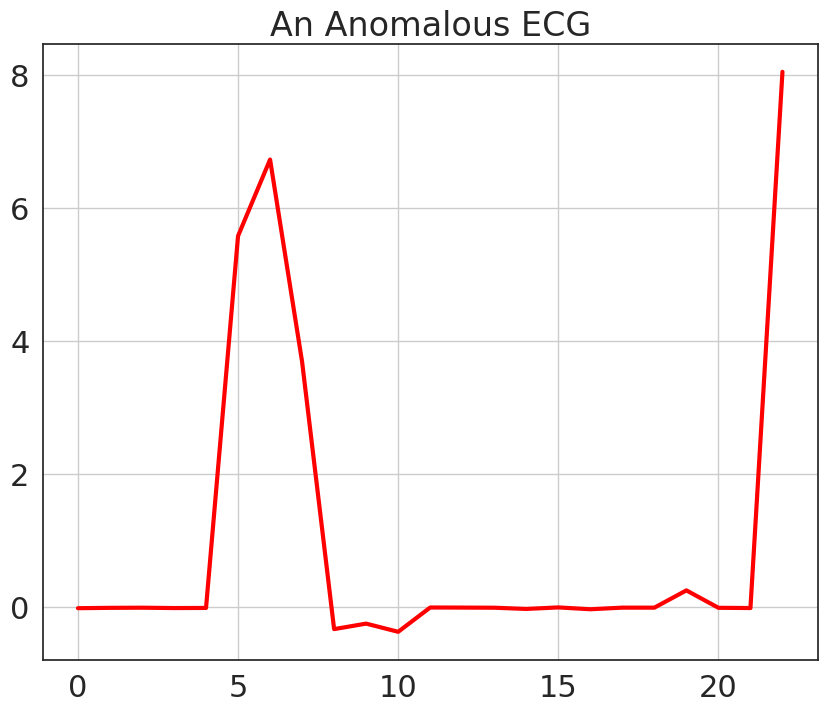

In [30]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.grid()
plt.plot(np.arange(23), X_train_abnromal[0],color='red',linewidth=3.0)
plt.title("An Anomalous ECG")
plt.show()

In [77]:
# This assumes that the positive class is labeled '1' and the negative class is '0'
positive_indices = train_labels == 1
negative_indices = train_labels == 0

# Now use these indices to separate out the positive and negative classes
X_positive_train = X_train_normalized[positive_indices]
y_positive_train = train_labels[positive_indices]

X_negative_train = X_train_normalized[negative_indices]
y_negative_train = train_labels[negative_indices]


In [82]:
from tensorflow.keras import layers, models, regularizers

class AnomalyDetector(models.Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu", activity_regularizer=regularizers.l1(10e-5)),
      layers.BatchNormalization(),
      layers.Dropout(0.1),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dropout(0.1),
      layers.Dense(32, activation="relu"),
      layers.Dense(62, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [83]:
autoencoder = AnomalyDetector()

In [84]:
autoencoder.compile(optimizer='adam', loss='mae')

In [85]:
history = autoencoder.fit(X_negative_train, X_negative_train,
          epochs=20,
          batch_size=512,
          validation_data=(X_val_normalized, X_val_normalized),
          shuffle=True)

Epoch 1/20
63/63 [==============================] - 3s 15ms/step - loss: 0.4612 - val_loss: 0.2501
Epoch 2/20
63/63 [==============================] - 1s 11ms/step - loss: 0.1557 - val_loss: 0.1300
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 0.1442 - val_loss: 0.1246
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 0.1407 - val_loss: 0.1203
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 0.1362 - val_loss: 0.1175
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.1330 - val_loss: 0.1144
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.1306 - val_loss: 0.1139
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 0.1301 - val_loss: 0.1136
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 0.1292 - val_loss: 0.1125
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 0.1283 - val_loss: 0.1122
Epoch 11/20
63/63

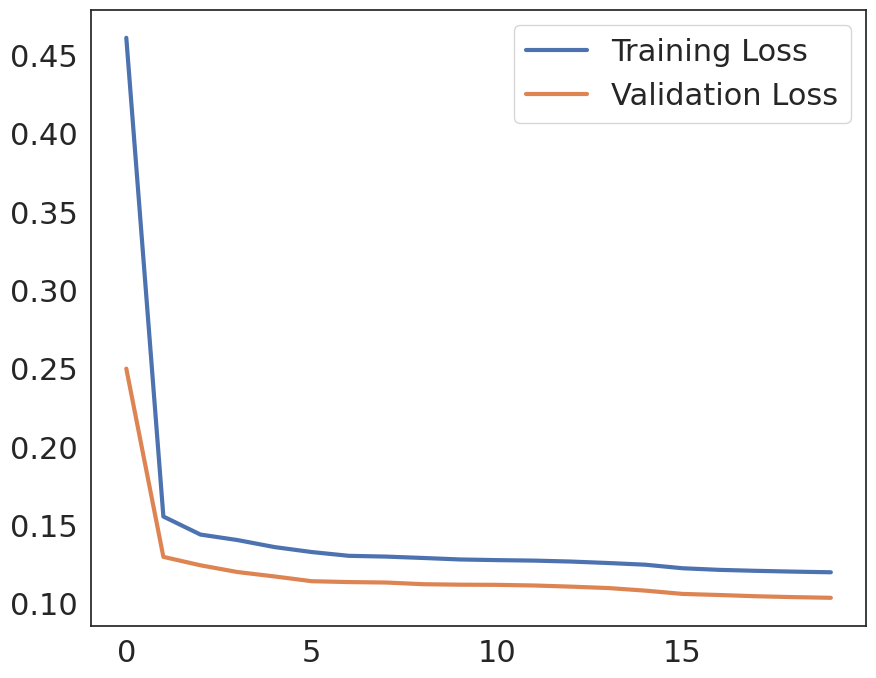

In [86]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss",linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.legend()

In [90]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [87]:
reconstructions = autoencoder.predict(X_negative_train)
train_loss = tf.keras.losses.mae(reconstructions, X_negative_train)

1001/1001 [==============================] - 2s 2ms/step


In [88]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.27922303406050186


In [43]:
X_test_normalized.shape

(17800, 23)

In [44]:
preds

<tf.Tensor: shape=(17800,), dtype=bool, numpy=array([ True,  True,  True, ...,  True,  True,  True])>

In [91]:
preds = predict(autoencoder, X_test_normalized, threshold)
print_stats(preds, y_test)

Accuracy = 0.07842696629213483
Precision = 0.01755542240862792
Recall = 0.9766666666666667


In [92]:
from tensorflow.keras import layers, models, regularizers, callbacks

class AnomalyDetector(models.Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu", activity_regularizer=regularizers.l1(10e-5)),
            layers.BatchNormalization(),
            layers.Dropout(0.1),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dropout(0.1),
            layers.Dense(32, activation="relu"),
            layers.Dense(62, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

# Early Stopping Callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning Rate Scheduler
lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (-epoch / 20))

history = autoencoder.fit(
    X_negative_train, X_negative_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_normalized, X_val_normalized),
    shuffle=True,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/50
501/501 [==============================] - 6s 6ms/step - loss: 0.1922 - val_loss: 0.1239 - lr: 0.0010
Epoch 2/50
501/501 [==============================] - 3s 5ms/step - loss: 0.1361 - val_loss: 0.1110 - lr: 8.9125e-04
Epoch 3/50
501/501 [==============================] - 3s 6ms/step - loss: 0.1259 - val_loss: 0.1093 - lr: 7.9433e-04
Epoch 4/50
501/501 [==============================] - 3s 5ms/step - loss: 0.1248 - val_loss: 0.1083 - lr: 7.0795e-04
Epoch 5/50
501/501 [==============================] - 3s 5ms/step - loss: 0.1239 - val_loss: 0.1072 - lr: 6.3096e-04
Epoch 6/50
501/501 [==============================] - 3s 6ms/step - loss: 0.1234 - val_loss: 0.1069 - lr: 5.6234e-04
Epoch 7/50
501/501 [==============================] - 2s 4ms/step - loss: 0.1229 - val_loss: 0.1066 - lr: 5.0119e-04
Epoch 8/50
501/501 [==============================] - 2s 4ms/step - loss: 0.1227 - val_loss: 0.1066 - lr: 4.4668e-04
Epoch 9/50
501/501 [==============================] - 2s 4ms/step - 

In [93]:
preds = predict(autoencoder, X_test_normalized, threshold)
print_stats(preds, y_test)

Accuracy = 0.07926966292134831
Precision = 0.01751334492892701
Recall = 0.9733333333333334


In [94]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model

class AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim, 1)),  # Ensure input is 3D
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Conv1DTranspose(latent_dim, 3, strides=2, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=2, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=2, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(input_dim)
        ])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded


# Set input_dim to the number of features in your dataset
input_dim = X_train.shape[-1]
latent_dim = 32

model = AutoEncoder(input_dim, latent_dim)
model.build((None, input_dim, 1))  # Additional 1 for the 3D input requirement
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mae")
model.summary()


Model: "auto_encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_18 (Sequential)  (None, 8, 32)             63264     
                                                                 
 sequential_19 (Sequential)  (None, 62)                573918    
                                                                 
Total params: 637182 (2.43 MB)
Trainable params: 636030 (2.43 MB)
Non-trainable params: 1152 (4.50 KB)
_________________________________________________________________


In [51]:
from tensorflow.keras.callbacks import EarlyStopping

In [95]:
epochs = 100
batch_size = 128
early_stopping = EarlyStopping(patience=10, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)


history = model.fit(X_negative_train, X_negative_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
226/226 [==============================] - 39s 154ms/step - loss: 0.6697 - val_loss: 0.1360
Epoch 2/100
226/226 [==============================] - 35s 154ms/step - loss: 0.1301 - val_loss: 0.0784
Epoch 3/100
226/226 [==============================] - 36s 157ms/step - loss: 0.0465 - val_loss: 0.0348
Epoch 4/100
226/226 [==============================] - 35s 157ms/step - loss: 0.0324 - val_loss: 0.0309
Epoch 5/100
226/226 [==============================] - 34s 151ms/step - loss: 0.0299 - val_loss: 0.0299
Epoch 6/100
226/226 [==============================] - 37s 163ms/step - loss: 0.0281 - val_loss: 0.0233
Epoch 7/100
226/226 [==============================] - 35s 154ms/step - loss: 0.0256 - val_loss: 0.0282
Epoch 8/100
226/226 [==============================] - 35s 156ms/step - loss: 0.0268 - val_loss: 0.0232
Epoch 9/100
226/226 [==============================] - 34s 149ms/step - loss: 0.0259 - val_loss: 0.0248
Epoch 10/100
226/226 [==============================] - 36s 159m

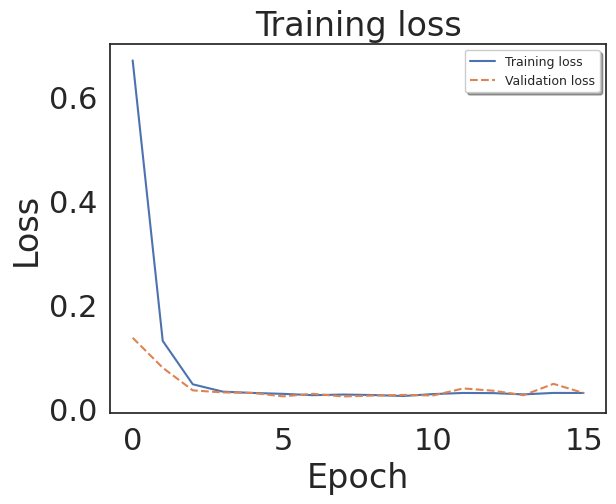

In [96]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss", ls="--")
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.title("Training loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [97]:
# positive_indices = train_labels == 1
negative_indices = y_test == 0

# Now use these indices to separate out the positive and negative classes
# X_positive_test = X_train_normalized[positive_indices]
# y_positive_train = train_labels[positive_indices]

X_negative_test = X_test_normalized[negative_indices]
y_negative_test = y_test[negative_indices]

In [54]:
X_negative_test

array([[-0.01304634, -0.01124826, -0.00918968, ..., -0.01014746,
        -0.01396284,  0.14402113],
       [-0.01553762, -0.01124826, -0.00918968, ..., -0.01014746,
        -0.01396284,  1.77226091],
       [-0.01678326, -0.01124784, -0.00918921, ..., -0.01014746,
        -0.01396284, -0.21590069],
       ...,
       [-0.01366916, -0.00839824, -0.00556951, ..., -0.01014746,
        -0.01396284, -0.21270235],
       [-0.0149148 , -0.01105981, -0.0090039 , ..., -0.01014746,
        -0.01396284,  2.8114723 ],
       [-0.01678326, -0.00955339, -0.00733283, ..., -0.01014746,
        -0.01396284, -0.21590069]])

In [98]:
train_mae = model.evaluate(X_negative_train, X_negative_train, verbose=0)
test_mae = model.evaluate(X_negative_test, X_negative_test, verbose=0)
anomaly_mae = model.evaluate(X_positive_train, X_positive_train, verbose=0)

print("Training dataset error: ", train_mae)
print("Testing dataset error: ", test_mae)
print("Anormaly dataset error: ", anomaly_mae)

Training dataset error:  0.02171267196536064
Testing dataset error:  0.0222566369920969
Anormaly dataset error:  0.025723345577716827


In [56]:
from tensorflow.keras.metrics import mae

In [99]:
def predict(model, X):
    pred = model.predict(X, verbose=False)
    loss = mae(pred, X)
    return pred, loss

_, train_loss = predict(model, X_negative_train)
_, test_loss = predict(model, X_negative_test)
_, anomaly_loss = predict(model, X_positive_train)
threshold = np.mean(train_loss) + np.std(train_loss)

In [100]:
def prepare_labels(model, train, test, anomaly, threshold):
    ytrue = np.concatenate((np.zeros(len(train) + len(test), dtype=int),
                            np.ones(len(anomaly), dtype=int)))

    _, train_loss = predict(model, train)
    _, test_loss = predict(model, test)
    _, anomaly_loss = predict(model, anomaly)

    # Ensure that the lengths of predictions match the expected lengths
    assert len(train_loss) == len(train), "Length mismatch in train predictions"
    assert len(test_loss) == len(test), "Length mismatch in test predictions"
    assert len(anomaly_loss) == len(anomaly), "Length mismatch in anomaly predictions"

    train_pred = (train_loss <= threshold).numpy().astype(int)
    test_pred = (test_loss <= threshold).numpy().astype(int)
    anomaly_pred = (anomaly_loss < threshold).numpy().astype(int)

    ypred = np.concatenate((train_pred, test_pred, anomaly_pred))

    return ytrue, ypred

In [101]:
def plot_confusion_matrix(model, train, test, anomaly, threshold=threshold):
    ytrue, ypred = prepare_labels(model, train, test, anomaly, threshold=threshold)
    accuracy = accuracy_score(ytrue, ypred)
    precision = precision_score(ytrue, ypred)
    recall = recall_score(ytrue, ypred)
    f1 = f1_score(ytrue, ypred)
    print(f"""\
        Accuracy: {accuracy:.2%}
        Precision: {precision:.2%}
        Recall: {recall:.2%}
        f1: {f1:.2%}\n
        """)

    cm = confusion_matrix(ytrue, ypred)
    cm_norm = confusion_matrix(ytrue, ypred, normalize="true")
    data = np.array([f"{count}\n({pct:.2%})" for count, pct in zip(cm.ravel(), cm_norm.ravel())]).reshape(cm.shape)
    labels = ["Anomaly", "Normal"]

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=data, fmt="", xticklabels=labels, yticklabels=labels)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix", weight="bold")
    plt.tight_layout()

        Accuracy: 37.96%
        Precision: 35.67%
        Recall: 98.48%
        f1: 52.37%

        


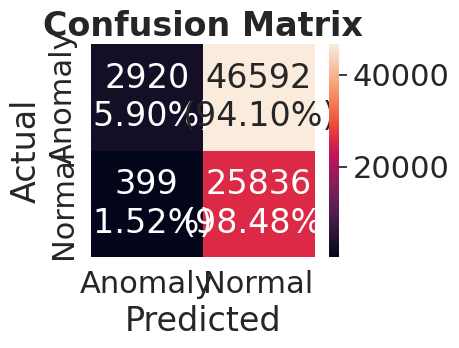

In [102]:
plot_confusion_matrix(model, X_negative_train, X_negative_test, X_positive_train, threshold=threshold)

In [103]:
CLASS_NAMES = ["Normal", "Anomaly"]

In [104]:
ytrue, ypred = prepare_labels(model, X_negative_train, X_negative_test, X_positive_train, threshold=threshold)
print(classification_report(ytrue, ypred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      Normal       0.88      0.06      0.11     49512
     Anomaly       0.36      0.98      0.52     26235

    accuracy                           0.38     75747
   macro avg       0.62      0.52      0.32     75747
weighted avg       0.70      0.38      0.25     75747

